# Data processing

# Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import resample

from constants import RANDOM_FOREST_PARAMS, NUM_SELECTED, CAT_SELECTED, SELECTED_FEATURES 

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import LearningCurveDisplay

from tqdm import tqdm

import warnings
from sklearn.exceptions import DataConversionWarning

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

from category_encoders import BinaryEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer

import optuna
from optuna.samplers import TPESampler
from xgboost import XGBClassifier

warnings.simplefilter(action='ignore', category=DataConversionWarning)
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

# Data Loading

In [3]:
X_test = pd.read_parquet(f"../../../../../data/interim/copper/X_test.parquet")
y_test = pd.read_parquet(f"../../../../../data/interim/copper/y_test_cat.parquet")

X_train = pd.read_parquet(f"../../../../../data/interim/copper/X_train.parquet")
y_train = pd.read_parquet(f"../../../../../data/interim/copper/y_train_cat.parquet")

# Pipe Setting

In [6]:
NUM_SELECTED = ['COPPER_GRADE', 'LOG_10_COPPER_GRADE', 'INITIAL_COST', 'LOG_10_INITIAL_COST_PER_TONNE',
       'INITIAL_COST_PER_TONNE', 'LOG_10_GOLD_DENSITY', 'GOLD_DENSITY']

CAT_SELECTED = ["GLOBAL_REGION"]

over = SMOTE(sampling_strategy="auto")
under = RandomUnderSampler(sampling_strategy="auto")

# Define the column renaming and extraction function
def rename_and_extract(X):
    # Renaming the PCA columns
    NEW_FEATURES_NAME = (
        [f"PCA_{i}" for i in range(len(NUM_SELECTED))] 
        + [f"GLOBAL_REGION_{i}" for i in range(3)]

        )

    X.columns = NEW_FEATURES_NAME
    
    # Extracting the desired columns
    return X[['PCA_0', 'PCA_1', 'PCA_2', 'GLOBAL_REGION_0', 'GLOBAL_REGION_1', 'GLOBAL_REGION_2']]

# Create the numeric and categorical transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('imputer', KNNImputer(n_neighbors=5)),
    ('pca', PCA(n_components=len(NUM_SELECTED)))
])

categorical_transformer = Pipeline(steps=[
    ('binary_encoder', BinaryEncoder())
])

# Preprocessor that applies transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUM_SELECTED),
        ('cat', categorical_transformer, ["GLOBAL_REGION"])
    ]
)

# Final pipeline with the renaming and extraction step
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('extractor', FunctionTransformer(rename_and_extract, validate=False))
])

# Now, you can fit and transform your data using final_pipeline
# Example: final_pipeline.fit_transform(X)

rkf= RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=42)

# Hyperparameter tunnig

In [18]:
def objective(trial):
    params = dict()
    params['n_estimators'] = trial.suggest_int('n_estimators', 1, 500, log = True)
    params['max_depth'] = trial.suggest_int('max_depth', 2, 6)
    params['learning_rate'] = trial.suggest_float('learning_rate', 0.01, 0.2)
    params['min_child_weight'] = trial.suggest_int('min_child_weight', 1, 5)
    params['gamma'] = trial.suggest_float('gamma', 0.0, 0.5)
    params['subsample'] = trial.suggest_float('subsample', 0.6, 0.9)
    params['colsample_bytree'] = trial.suggest_float('colsample_bytree', 0.6, 0.9)
    params['reg_alpha'] = trial.suggest_float('reg_alpha', 0.0, 0.5)
    params['reg_lambda'] = trial.suggest_float('reg_lambda', 0.0, 0.5)
    params['importance_type'] = trial.suggest_categorical('importance_type', ['gain', 'weight', 'cover', 'total_gain', 'total_cover'])
    params['random_state'] = trial.suggest_int('random_state', 0, 100)
    params['n_jobs'] = 4

    steps_list = [('preprocessor', preprocessor),
                  ('over', over),
                  ('under', under),
                  ('classifier', XGBClassifier(**params))]
    
    pipe = ImbPipeline(steps_list)
    
    scores = cross_val_score(pipe, X_train, y_train, cv=rkf, scoring="roc_auc")
    std2 = np.std(scores)
    std = np.sqrt(std2)
    mean = np.mean(scores)

    variation = mean/std
    
    if variation == np.inf:
        variation = 0
    else:
        variation = np.log10(variation)

    return mean + variation

study = optuna.create_study(directions=['maximize'], 
                            storage='sqlite:///xgboost_model.db',
                            study_name="xgboost_model",
                            load_if_exists=True,
                            sampler=TPESampler(multivariate=True,
                                               n_startup_trials = 100, group=True,
                                               warn_independent_sampling=False,
                                               n_ei_candidates=50,
                                               constant_liar=True))

study.optimize(objective, n_trials=1000)

[I 2024-11-01 17:50:33,178] Using an existing study with name 'xgboost_model' instead of creating a new one.


[I 2024-11-01 17:50:35,243] Trial 2058 finished with value: 1.105304350148155 and parameters: {'n_estimators': 18, 'max_depth': 5, 'learning_rate': 0.04176618509127451, 'min_child_weight': 1, 'gamma': 0.49364344285992007, 'subsample': 0.7257679547207723, 'colsample_bytree': 0.7924271468477854, 'reg_alpha': 0.24073338224266416, 'reg_lambda': 0.403373456070498, 'importance_type': 'cover', 'random_state': 94}. Best is trial 1537 with value: 1.4006786142800483.
[I 2024-11-01 17:50:36,335] Trial 2059 finished with value: 1.19359887662592 and parameters: {'n_estimators': 41, 'max_depth': 4, 'learning_rate': 0.010903579763820727, 'min_child_weight': 3, 'gamma': 0.49866416395423346, 'subsample': 0.760825386222924, 'colsample_bytree': 0.8692765486673484, 'reg_alpha': 0.36370574368804326, 'reg_lambda': 0.3153948696076843, 'importance_type': 'cover', 'random_state': 86}. Best is trial 1537 with value: 1.4006786142800483.
[I 2024-11-01 17:50:37,193] Trial 2060 finished with value: 1.06915767287189

In [17]:
plot_optimization_history(study)

In [18]:
#optuna.visualization.plot_pareto_front(study, target_names=["mean ROC-AUC", "std ROC-AUC"])

In [19]:
plot_param_importances(study)

In [9]:
params = study.best_params
params

{'n_estimators': 11,
 'max_depth': 5,
 'learning_rate': 0.048174437212056415,
 'min_child_weight': 4,
 'gamma': 0.0758572463850698,
 'subsample': 0.8702056291483529,
 'colsample_bytree': 0.8559504849699301,
 'reg_alpha': 0.46062825988648115,
 'reg_lambda': 0.43339785627319266,
 'importance_type': 'weight',
 'random_state': 61}

# Learning Curve

In [10]:
over = SMOTE(sampling_strategy="auto")
under = RandomUnderSampler(sampling_strategy="auto")

numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('imputer', KNNImputer(n_neighbors=5)),
        ('pca', PCA(n_components=len(NUM_SELECTED)))
    ])

categorical_transformer = Pipeline(steps=[
    ('binary_encoder', BinaryEncoder())
])

preprocessor = ColumnTransformer(
        transformers=[
            ('num_pca', numeric_transformer, NUM_SELECTED),
            ('cat', categorical_transformer, ["GLOBAL_REGION"])
        ]
    )

steps_list =[('preprocessor', preprocessor),
        ('over', over),
        ('under', under),]


model = XGBClassifier(**params)

steps_list.append(('classifier', model))

pipe = ImbPipeline(steps_list)

In [11]:
common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.01, 1, 100),
    "cv": RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=42),
    "scoring": "roc_auc",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
}

Text(0.5, 1.0, 'Learning Curve for XGBClassifier')

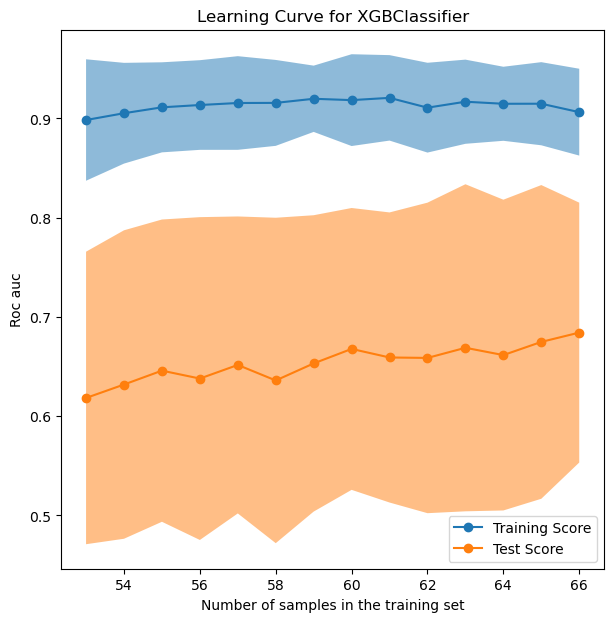

In [12]:
fig, ax = plt.subplots(figsize=(7, 7), sharey=True)

LearningCurveDisplay.from_estimator(pipe, **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {model.__class__.__name__}")

# Bootstraping Error Extimation

In [13]:
pipe.fit(X_train[NUM_SELECTED + ["GLOBAL_REGION"]], y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pca',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   KNNImputer()),
                                                                  ('pca',
                                                                   PCA(n_components=7))]),
                                                  ['COPPER_GRADE',
                                                   'LOG_10_COPPER_GRADE',
                                                   'INITIAL_COST',
                                                   'LOG_10_INITIAL_COST_PER_TONNE',
                                                   'INITIAL_COST_PER_TONNE',
                                                   'LOG_10_GOLD_DENSITY',
                                                   'GOLD_DENSITY']),
                                                 ('cat',
                                                  Pipeline(steps=[('bi...
                               grow_policy=None, importance_type='weight',
                               interaction_constraints=None,
                               learning_rate=0.048174437212056415, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=5,
                               max_leaves=None, min_child_weight=4, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=11, n_jobs=None,
                               num_parallel_tree=None, random_state=61, ...))])

## Treino

In [19]:
y_prob = pipe.predict_proba(X_train)[:, 1]

roc_auc = roc_auc_score(y_train.values, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

ROC AUC Score: 0.8690


In [20]:
bootstrap_dataframes = [X_train.sample(X_train.shape[0], replace=True) for _ in range(1000)]

lines = []
roc_auc_scores = []

for i, df in tqdm(enumerate(bootstrap_dataframes)):

    y_prob = pipe.predict_proba(df)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_train.loc[df.index].values, y_prob)
    line_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds, 'Bootstrap': i})
    lines.append(line_df)

    roc_auc = roc_auc_score(y_train.loc[df.index].values, y_prob)
    roc_auc_scores.append(roc_auc)

roc_df = pd.concat(lines)

0it [00:00, ?it/s]

1000it [00:09, 108.06it/s]


<Axes: ylabel='Count'>

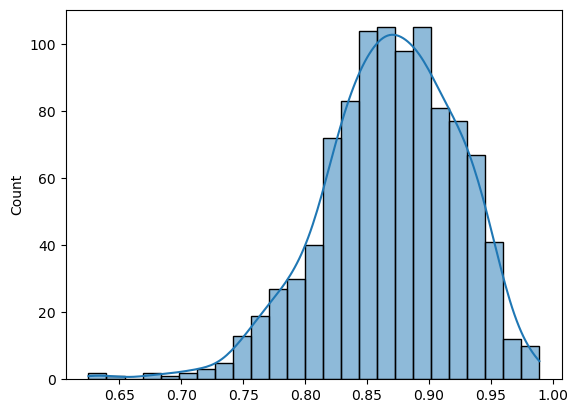

In [21]:
sns.histplot(roc_auc_scores, kde=True)

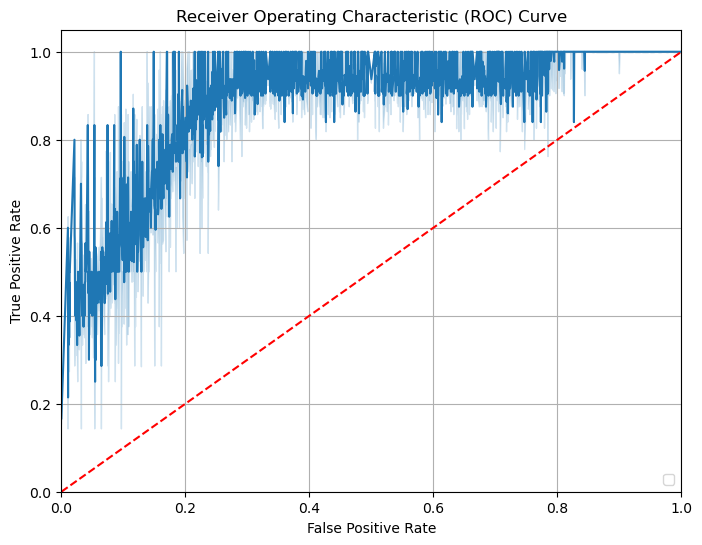

In [22]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='FPR', y='TPR', data=roc_df, estimator='median')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Teste

In [23]:
y_prob = pipe.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test.values, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

ROC AUC Score: 0.6818


In [ ]:
bootstrap_dataframes = [X_test.sample(X_test.shape[0], replace=True) for _ in range(1000)]

def get_bootstrap_roc_curve(pipe, df, y_test, i):

    y_prob = pipe.predict_proba(df)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test.loc[df.index].values, y_prob)
    line_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds, 'Bootstrap': i})

    return line_df

lines = [get_bootstrap_roc_curve(pipe, df, y_test, i) for i, df in tqdm(enumerate(bootstrap_dataframes))]

def get_roc_auc(pipe, df, y_test):
    y_prob = pipe.predict_proba(df)[:, 1]
    roc_auc = roc_auc_score(y_test.loc[df.index].values, y_prob)
    return roc_auc

roc_auc_scores = [get_roc_auc(pipe, df, y_test) for df in tqdm(bootstrap_dataframes)]

roc_df = pd.concat(lines)


32it [00:00, 94.17it/s]

411it [00:03, 132.60it/s]

<Axes: ylabel='Count'>

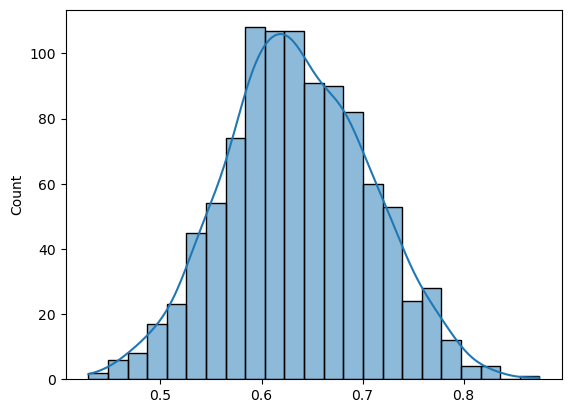

In [ ]:
sns.histplot(roc_auc_scores, kde=True)

In [ ]:
np.quantile(roc_auc_scores, [0.05, 0.5, 0.95])

array([0.52309198, 0.63261244, 0.75781265])

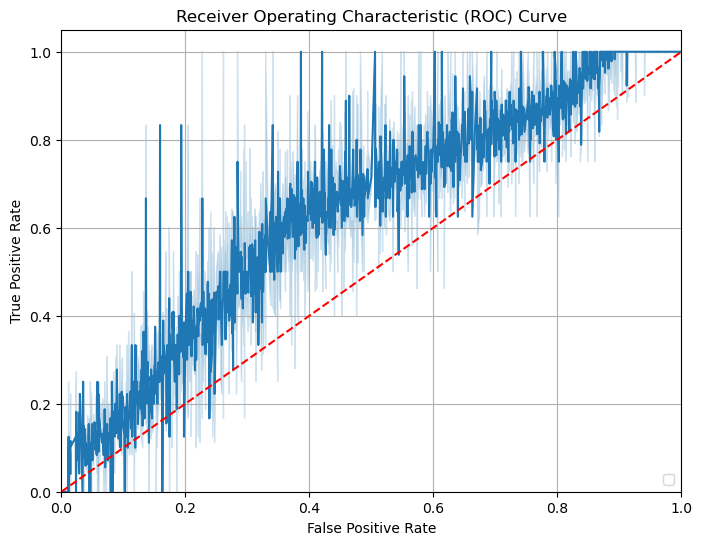

In [ ]:
# Step 7: Plot the ROC curve
plt.figure(figsize=(8, 6))
sns.lineplot(x='FPR', y='TPR', data=roc_df, estimator='median')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()